## Characteristics of Hyperspectral Data

Hyperspectral data presents several important characteristics:

- **High Dimensionality**: Each sample contains hundreds of spectral bands, creating a very high-dimensional feature space (often >200 dimensions)

- **Functional Nature**: Spectra are continuous functions sampled at different wavelengths, implying:
    - Strong correlation between adjacent spectral bands
    - Statistically dependent dimensions
    - Smooth and continuous underlying structure

In this notebook, we will address supervised learning tasks with two types of target variables:

- **Classification**: Prediction of qualitative variables (e.g., material type, health status)
- **Regression**: Prediction of continuous quantitative variables (e.g., chemical concentration, physical properties)

## Setting up the environment
## Importing Libraries and Project Code

In this section, we will import the necessary libraries and project code to work with hyperspectral data:

- **pandas**: For data manipulation and analysis
- **numpy**: For numerical computations  
- **Dataset**: Our custom class for handling hyperspectral datasets

We will also set up the paths to access our data files.

The code below:
1. Sets up the project root path
2. Adds it to Python's path to enable imports
3. Imports our custom Dataset class
4. Defines the data directory path




In [26]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path  # Au lieu de import os
# Get current notebook path
notebook_path = Path.cwd()
# Go up one level to reach project root
ROOT_PATH = notebook_path.parent
# Add root path to sys.path to enable imports
sys.path.insert(0, str(ROOT_PATH))
print(sys.path)
# Now you can import Dataset
from src.dataset import Dataset, GroupConfig, InputType
from scripts.dataLoading import (
    snv_transformer, 
    sg_smoother,
    derivative1,
    derivative2
)
# Define data path
DATA_PATH = ROOT_PATH / "data"

# Read data for 3 classes dataset
mat_3cl = pd.read_csv(DATA_PATH / "3cl" / "spectra_3cl.csv", sep=";", index_col=0)
simple_classes_3cl = pd.read_csv(DATA_PATH / "3cl" / "classes_3cl.csv", sep=";", index_col=0)

# Read leaves data
dt_leaves = pd.read_csv(DATA_PATH / "3cl" / "dt_leaves.csv", sep=";")

['c:\\Users\\Guilhem\\code\\SUPAGRO\\hyperspectral-analysis', 'C:\\Users\\Guilhem\\code\\SUPAGRO\\hyperspectral-analysis', 'c:\\Users\\Guilhem\\code\\SUPAGRO\\hyperspectral-analysis', 'c:\\Users\\Guilhem\\code\\SUPAGRO\\hyperspectral-analysis\\notebooks', 'c:\\Users\\Guilhem\\.conda\\envs\\datascience\\python310.zip', 'c:\\Users\\Guilhem\\.conda\\envs\\datascience\\DLLs', 'c:\\Users\\Guilhem\\.conda\\envs\\datascience\\lib', 'c:\\Users\\Guilhem\\.conda\\envs\\datascience', '', 'c:\\Users\\Guilhem\\.conda\\envs\\datascience\\lib\\site-packages', 'c:\\Users\\Guilhem\\.conda\\envs\\datascience\\lib\\site-packages\\win32', 'c:\\Users\\Guilhem\\.conda\\envs\\datascience\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Guilhem\\.conda\\envs\\datascience\\lib\\site-packages\\Pythonwin', 'c:\\Users\\Guilhem\\.conda\\envs\\datascience\\lib\\site-packages\\setuptools\\_vendor']


## Dataset Description

The dataset consists of three main files containing 1-dimensional hyperspectral measurements and associated metadata. The spectral data represents averaged reflectance values across entire leaf images, meaning there is no spatial information preserved - each wavelength measurement is averaged over the complete image area.

### Data Files
- **spectra_3cl.csv**: Contains the spectral measurements (reflectance values at different wavelengths)
- **classes_3cl.csv**: Contains binary classification labels:
  - num_classe: Class number (1, 2 or 3)
  - biotic: Presence of biotic stress (1=yes, 0=no)  
  - abiotic: Presence of abiotic stress (1=yes, 0=no)
  - healthy: Healthy status (1=healthy, 0=stressed)

- **dt_leaves.csv**: Contains additional metadata about the samples:
  - Categorical variables:
    - variety: Plant variety
    - symptom: Type of observed symptoms 
    - plotLocation: Location of measurement
  - Quantitative variables:
    - Chl: Chlorophyll content
    - Flav: Flavonoid content
    - NBI: Nitrogen Balance Index
    - Anth: Anthocyanin content

### Dataset Structure

The data represents leaf measurements with:
- Response variables: Health status (healthy/stressed) and stress type (biotic/abiotic)
- Predictors: 1D spectral reflectance measurements (averaged across each leaf image)
- Additional categorical variables: Variety, symptoms and location information

The samples are labeled with a unique directoryName that links the spectral measurements to their corresponding metadata and class labels.


In [27]:
# Read data for 3 classes dataset
mat_3cl = pd.read_csv(DATA_PATH / "3cl" / "spectra_3cl.csv", sep=";", index_col=0)
simple_classes_3cl = pd.read_csv(DATA_PATH / "3cl" / "classes_3cl.csv", sep=";", index_col=0)

# Read leaves data
dt_leaves = pd.read_csv(DATA_PATH / "3cl" / "dt_leaves.csv", sep=";")

# Create and merge data for 3 classes
# Create dataframe by merging on directoryName column
data_3cl = simple_classes_3cl.merge(mat_3cl, left_index=True, right_index=True)  # Merge classes and spectral data
data_3cl = data_3cl.merge(dt_leaves, left_index=True, right_on='directoryName')  # Add categorical variables using directoryName as key
data_3cl = data_3cl.drop(['directoryName', 'imageID'], axis=1)  # Remove directoryName column

print(data_3cl.head())

# Convert all categorical columns
categorical_columns = ['variety', 'symptom', 'plotLocation', 'num_classe', 'biotic', 'abiotic', 'healthy']
for col in categorical_columns:
    data_3cl[col] = data_3cl[col].astype('category')

   num_classe  biotic  abiotic  healthy    400.2   403.09    405.97    408.85  \
0           1       1        0        0  0.15843  0.14519  0.136420  0.128180   
1           1       1        0        0  0.11722  0.10699  0.099803  0.094314   
2           1       1        0        0  0.13126  0.11673  0.108970  0.102280   
3           1       1        0        0  0.11705  0.10660  0.097402  0.093215   
4           1       1        0        0  0.13328  0.11968  0.110760  0.105290   

     411.74    414.63  ...    997.4   1000.5  collectionDate  acquisitionDate  \
0  0.123440  0.116810  ...  0.88797  0.90026      10/09/2020       10/09/2020   
1  0.089953  0.086411  ...  0.73640  0.74440      10/09/2020       10/09/2020   
2  0.096992  0.091603  ...  0.81490  0.81010      10/09/2020       10/09/2020   
3  0.087743  0.083180  ...  0.67270  0.67016      10/09/2020       10/09/2020   
4  0.099521  0.094643  ...  0.83286  0.83035      10/09/2020       10/09/2020   

   plotLocation  variety  

We can also complements our spectral data with metadata, but beware that doing so can change the interpretation of results or use of the algorithm.

For exemple, if we add the acquisitionDate, treatmentDate or plotLocation, we do train our model to predict only in these modalities. 

It is different to say "I want to predict the class of the plant based on the spectra" from 
It is different to say "I want to predict the class of the plant based on the spectra, in one of these 3 plot". Only a discussion and understanding of the domain can help to decide what we should keep or skip.  



## Data cleaning and pre-treatment

Spectral data preprocessing is a important step in chemometrics and hyperspectral analysis, especially in the case of machine learning. Raw spectral measurements often contain various sources of noise, baseline variations, and scatter effects that can mask the relevant chemical or physical information. Proper preprocessing techniques help to:

- Remove or minimize unwanted spectral variations
- Enhance the quality of subsequent analysis
- Improve model performance and robustness
- Facilitate better interpretation of results

### Common Preprocessing Techniques

#### Standard Normal Variate (SNV)

Standard Normal Variate (SNV) is a widely used transformation in spectroscopy that helps to:

- Remove multiplicative interference of scatter
- Correct for baseline shifts
- Normalize each spectrum individually

The SNV transformation is performed by:
1. Centering each spectrum around zero by subtracting its mean
2. Scaling each spectrum by its standard deviation

#### Savitzky-Golay Filter

The [Savitzky-Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) is a powerful smoothing and differentiation method that:

- Reduces random noise while preserving higher moments of the signal
- Can compute derivatives of the spectral data
- Maintains peak shape and width

Key parameters include:
- Window size (filter length)
- Polynomial order
- Derivative order

### Additional Preprocessing Steps

Other common preprocessing techniques include:

- **Baseline Correction**: Removes systematic baseline shifts
- **Multiplicative Scatter Correction (MSC)**: Alternative to SNV, corrects for light scatter effects by using a reference spectrum
- **Derivatives**: Enhances spectral features and removes baseline effects
  - First derivative: removes constant baseline offsets
  - Second derivative: removes linear baseline effects

## Best Practices

1. **Document all preprocessing steps** applied to the data
2. **Validate preprocessing** impact on model performance
3. **Consider the physical meaning** of each preprocessing step
4. **Apply preprocessing consistently** to both training and test data
5. **Avoid over-processing** which might remove relevant information

## References and Further Reading

- [Chemometrics in Spectroscopy](https://en.wikipedia.org/wiki/Chemometrics)
- [Near-infrared spectroscopy](https://en.wikipedia.org/wiki/Near-infrared_spectroscopy)
- [Digital Signal Processing](https://en.wikipedia.org/wiki/Digital_signal_processing)


## Data Visualization and Preleminary Analysis

Data visualization plays a crucial role in understanding complex hyperspectral datasets. Through effective visualization, we can:
- Identify patterns and trends in spectral signatures
- Detect outliers and anomalies
- Understand relationships between different wavelengths
- Validate our preprocessing steps

For the sake of code length, I will use some custom defined functions to display and explore data. Those resources will be available to use, but not mandatory.

In [39]:
# Create group configurations
groups = [
    GroupConfig(
        features_label=mat_3cl.columns.tolist(),
        type=InputType.FUNCTIONAL,
        group_name="spectra"
    )
]

# Create dataset with both spectral and metadata inputs
dataset_3cl = Dataset(
    data=data_3cl,
    input_labels=mat_3cl.columns.tolist(),
    input_groups=groups
)
dataset_3cl.get_output_data().describe(include="all")

,num_classe,biotic,abiotic,healthy,collectionDate,acquisitionDate,plotLocation,variety,symptom,Chl,Flav,NBI
count,204.0,204.0,204.0,204.0,204,204,204,204,204,204.000000,204.000000,204.000000
unique,3.0,2.0,2.0,2.0,4,4,5,7,12,NaN,NaN,NaN
top,1.0,1.0,0.0,0.0,10/09/2020,10/09/2020,Couffouleux,Gamay,flavescence doree,NaN,NaN,NaN
freq,136.0,136.0,176.0,164.0,120,120,50,50,80,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.046010,3.345054,6.568284
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.324706,0.575730,3.372776
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.866000,1.311000,0.840000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.962250,2.962500,4.060000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.431000,3.406500,5.685000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.918750,3.781250,8.765000


This quick summary gives informations of the various variables we could be interested in (others that spectra). Biotic, abiotic, healthy are binary variable:biotic and abiotic doesn't appear to be mutually exclusive neither => it is relevant to ask to the fied expert about the differences. CollectionDate, acquisitionDate and plotLocation could be considered metadata, as they are quite tied to the data acquisition process. Variety and symptom are categorical variables, with "a lot" of classes, and probably unbalanced repartition ('flavescence doree', which is the most represented class of symptom, take 80 datum from the 204 composing the dataset, letting only 124 datum to represents the 11 others classes). Chl, Flav and NBI are numerical variables.

We could also make graphical representation of our dataset, especially by putting into emphasis the spectra and the possible variables of interest. 

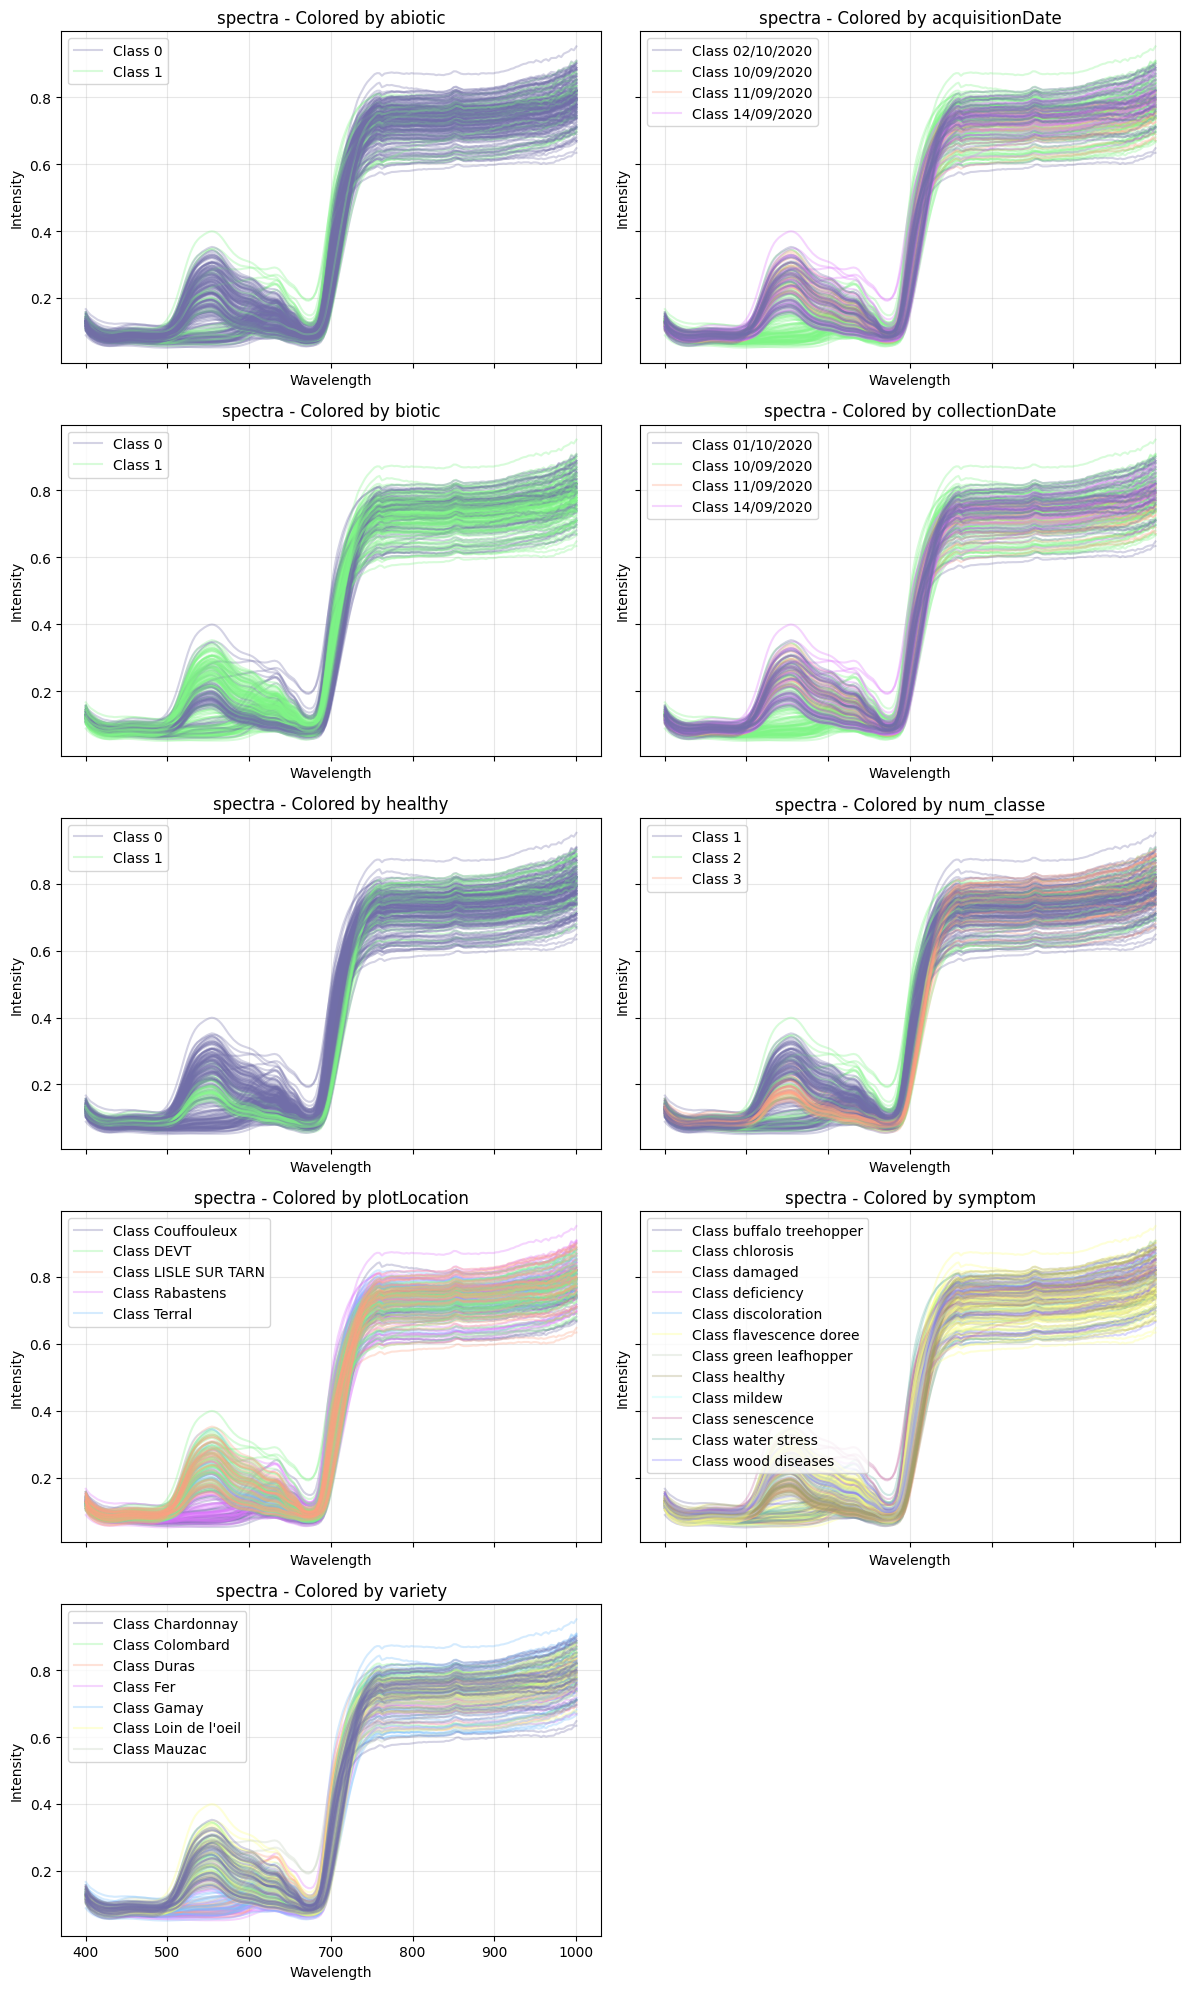

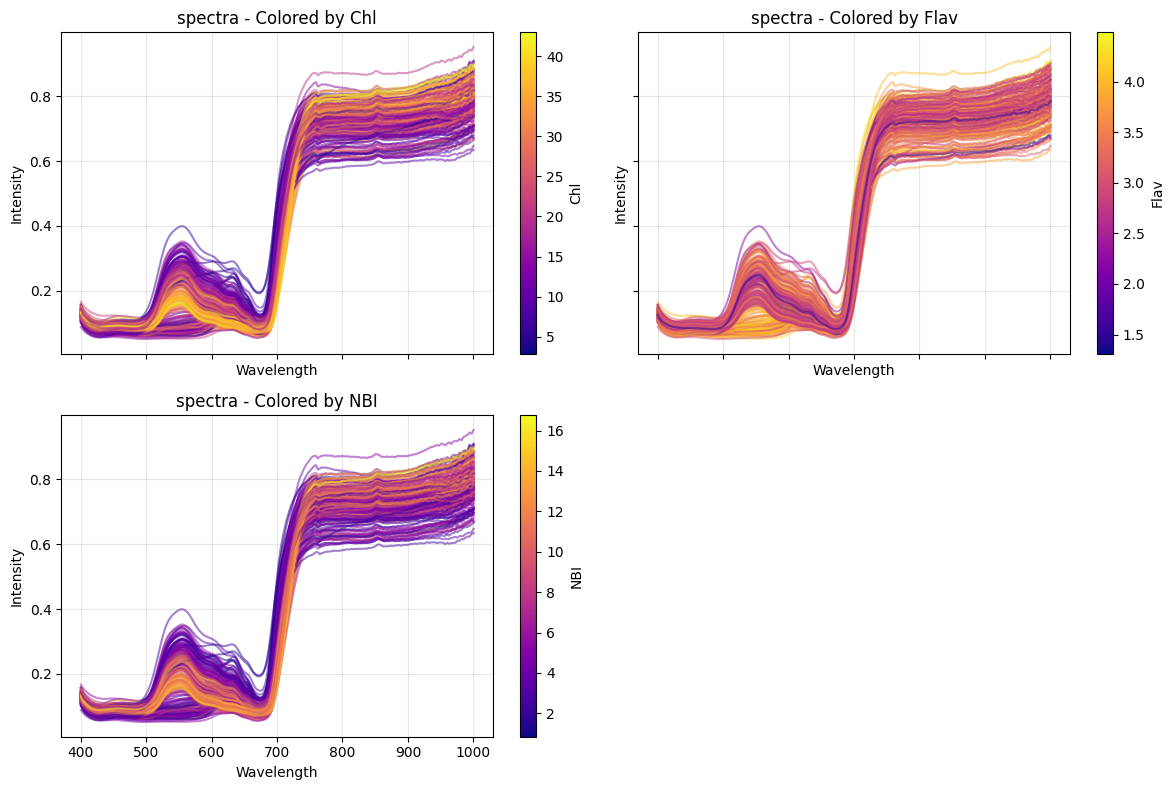

In [38]:
# Visualize the dataset with custom subplot parameters
dataset_3cl.show(
    group_labels="spectra",
    common_subplot_params={
        "ncols": 2,
        "sharex": True,
        "sharey": True,
    }
)


To complements those functional representation, we can also use PCA-like visualization techniques to represent the distribution based on a large number of non-numerical dimensions. 

*N.B*: When using PCA method, the order of the column/variables is not relevant. The latent correlation between them will be computed via the algorithm.

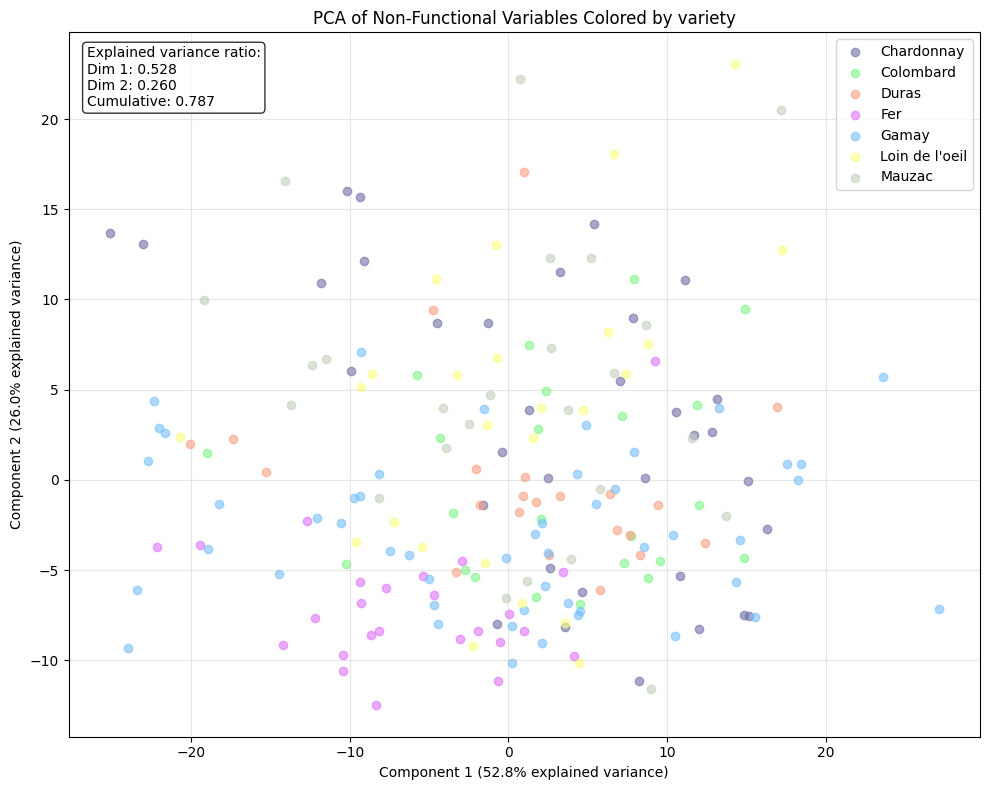

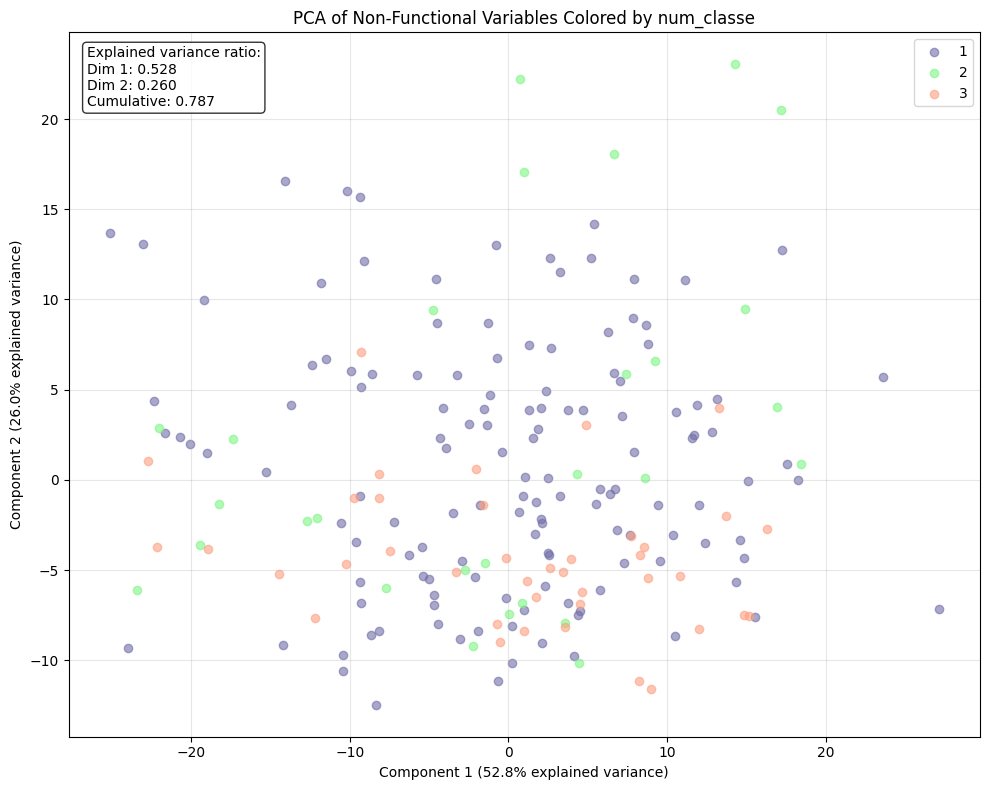

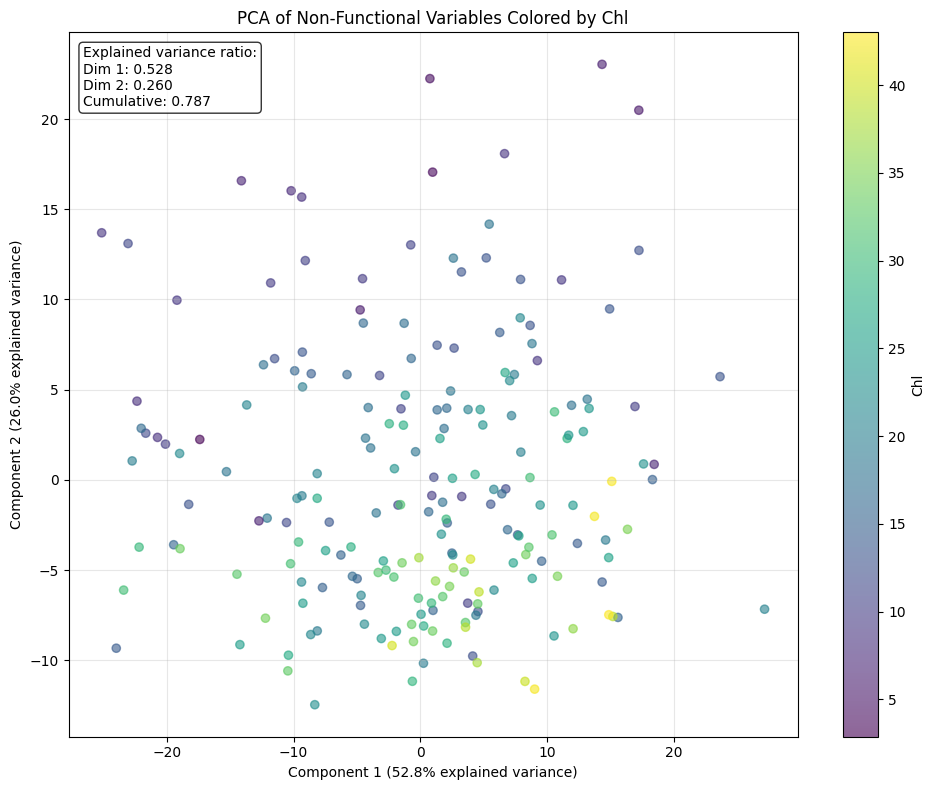

In [12]:


# Create dataset with both spectral and metadata inputs
dataset_3cl_bis = Dataset(
    data=data_3cl,
    input_labels=mat_3cl.columns.tolist(),
    input_groups=[GroupConfig(
        features_label=mat_3cl.columns.tolist(),
        type=InputType.NON_FUNCTIONAL,
        group_name="full")
    ]
)
dataset_3cl_bis.show(output_labels=["variety", "num_classe", "Chl"])

ACP representation efficiently capture variablity of our dataset (2 axis capture ~79% of the total input variablity), and we colored the dot by a variable of interest. We can see some patterns, or areas, not linarly separable (in the displayed plan), forming. Still, the variable of interest play no role in the way we process the ACP, as it is used on the features data only, and we have no guarantee that this dimension reduction will serve us to explain the variables of interest: the ACP is primarly used to display the dataset, it is not a prediction model by itself.

## Data cleaning and pretreatment  

We can also improve our understanding of the data by applying State of the Art (SOTA) pre-treatment and normalization. In the case of spectral data, it is about SNV and the various SigVol filtering.  

### **Standard Normal Variate (SNV)**  
SNV is a normalization technique that removes multiplicative scatter effects and baseline shifts in spectral data. It works by centering each spectrum to a mean of zero and scaling it to unit variance, helping to reduce noise and enhance signal clarity.  

### **Signal and Volume (SigVol) Filtering**  
SigVol filtering encompasses various methods used to enhance spectral data quality. These techniques help in removing unwanted variations due to instrumental noise, environmental factors, or sample inconsistencies. Common approaches include:  
- **Savitzky-Golay filtering**: A smoothing method that preserves peak shapes while reducing noise.  
- **Derivative transformations**: These help in highlighting small variations in spectra by emphasizing inflection points and reducing baseline effects.  
- **Mean and variance scaling**: Standardization techniques that improve comparability between spectra.  

### **Combining SNV and SigVol Filtering**  
These transformations are not mutually exclusive; they can be combined for improved performance. Applying SNV followed by appropriate SigVol filtering can enhance signal quality, remove artifacts, and make spectral patterns more interpretable for further analysis.


For the next plotting, I will only study *num_classe*, *variety* and *Chl* variables, to reduce the plotting overhead, and different categoris of issues.

**N.B:** The transformer are available in the same way the dataset function is. Take a look at the source code if you are interested at coding.

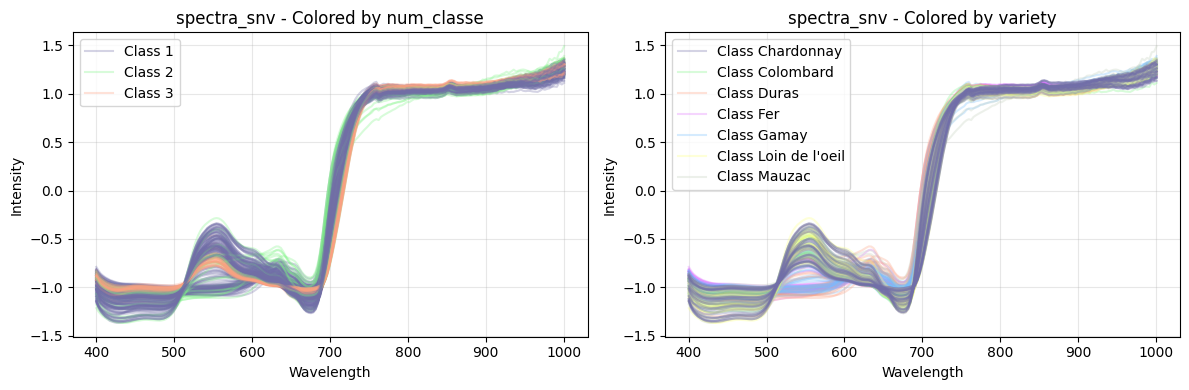

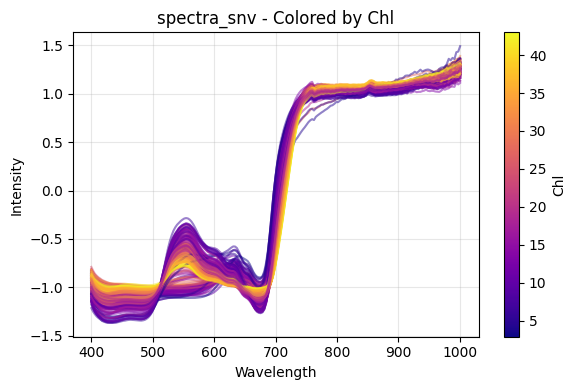

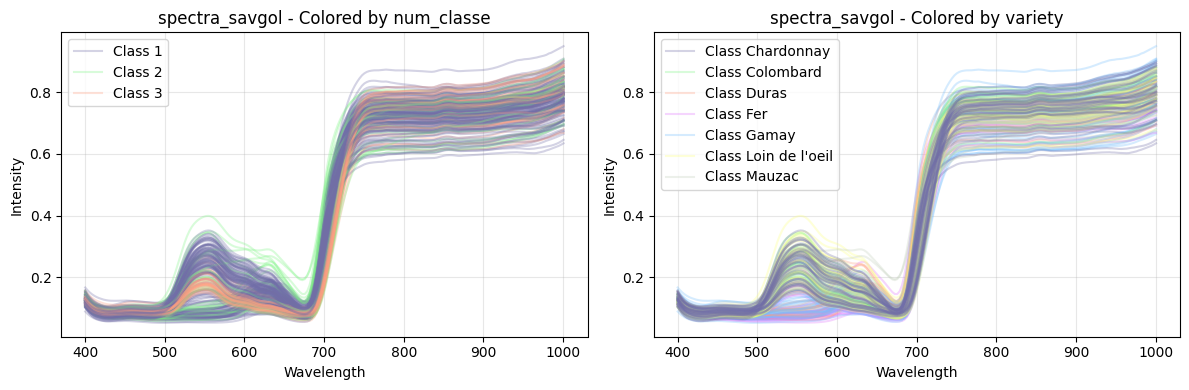

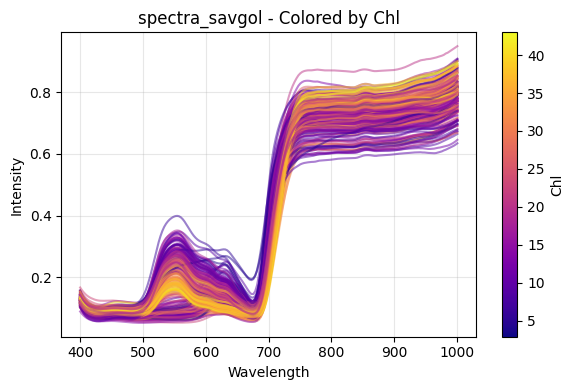

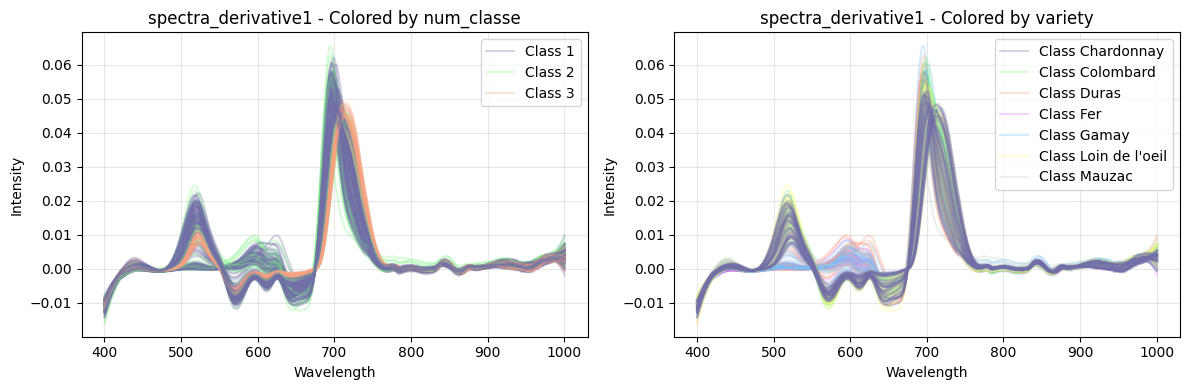

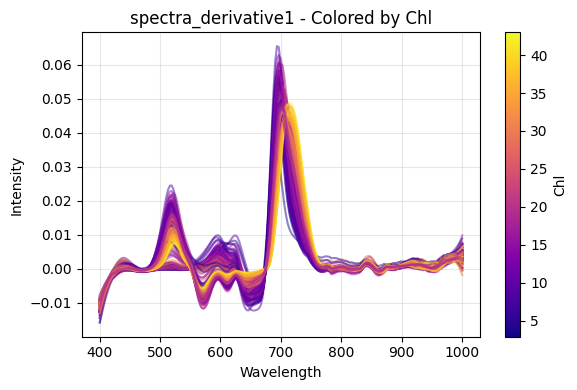

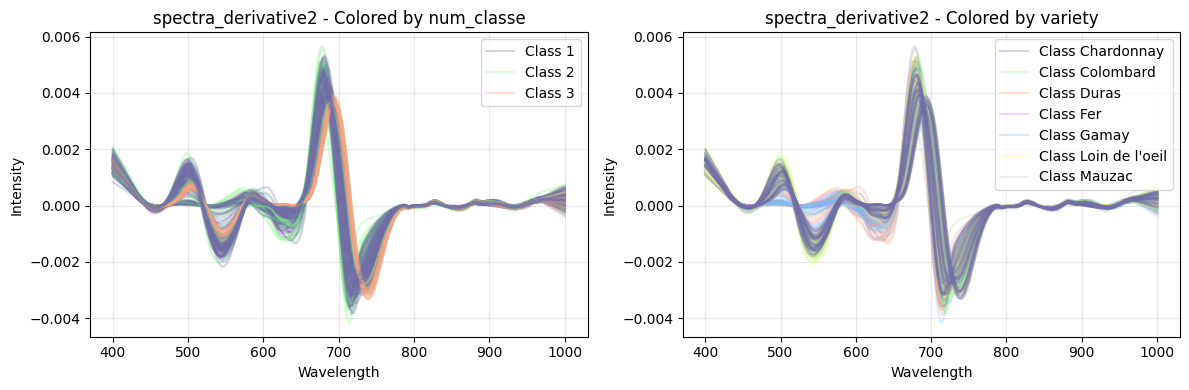

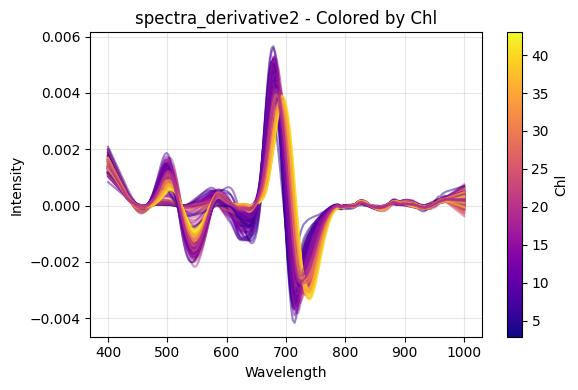

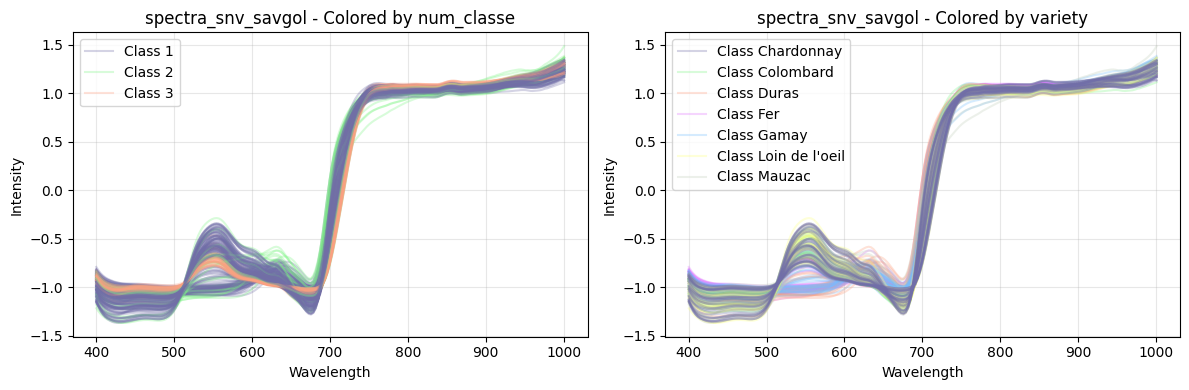

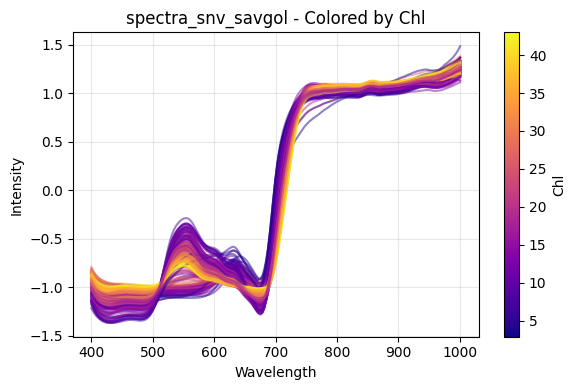

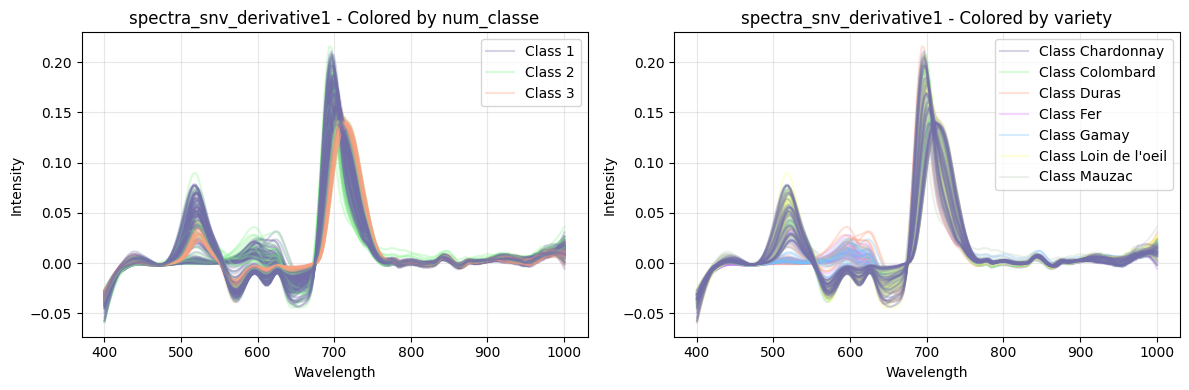

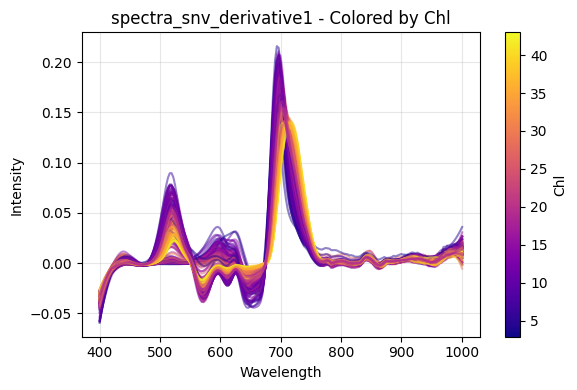

In [43]:
from src.transformers import (
    SNVTransformer,
    SavitzkyGolayTransformer,
    DerivativeTransformer,
)

# Extract spectral data for preprocessing
X_spectral = dataset_3cl.get_group_data('spectra')

# ====== Apply preprocessing transformations ======

# 1. Standard Normal Variate (SNV)
snv_transformer = SNVTransformer()
X_snv = snv_transformer.fit_transform(X_spectral)

# 2. Savitzky-Golay smoothing
sg_smoother = SavitzkyGolayTransformer(window_length=11, polyorder=3)
X_sg = sg_smoother.fit_transform(X_spectral)

# 3. First derivative (Savitzky-Golay)
derivative1 = DerivativeTransformer(order=1, window_length=15, polyorder=3)
X_d1 = derivative1.fit_transform(X_spectral)

# 4. Second derivative (Savitzky-Golay)
derivative2 = DerivativeTransformer(order=2, window_length=21, polyorder=3)
X_d2 = derivative2.fit_transform(X_spectral)

# 5. Combination: SNV + smoothing
X_snv_sg = sg_smoother.fit_transform(X_snv)

# 6. Combination: SNV + first derivative
X_snv_d1 = derivative1.fit_transform(X_snv)

# Create transformed datasets
transformed_datasets = {}

spectral_cols = mat_3cl.columns.tolist()

def create_transformed_dataset(X_transformed: np.ndarray, name: str) -> Dataset:
    """Create a dataset with transformed spectral data."""
    # Create a copy of the original data
    df_transformed = data_3cl.copy()
    # Replace spectral columns with transformed data
    df_transformed[spectral_cols] = X_transformed
    
    return Dataset(
        data=df_transformed,
        input_labels=spectral_cols,
        output_labels=["num_classe", "variety", "Chl"],
        input_groups=[
            GroupConfig(
                features_label=spectral_cols,
                type=InputType.FUNCTIONAL,
                group_name=f"spectra_{name}"
            )
        ]
    )

# Create datasets for each transformation
transformed_datasets["snv"] = create_transformed_dataset(X_snv, "snv")
transformed_datasets["savgol"] = create_transformed_dataset(X_sg, "savgol")
transformed_datasets["derivative1"] = create_transformed_dataset(X_d1, "derivative1")
transformed_datasets["derivative2"] = create_transformed_dataset(X_d2, "derivative2")
transformed_datasets["snv_savgol"] = create_transformed_dataset(X_snv_sg, "snv_savgol")
transformed_datasets["snv_derivative1"] = create_transformed_dataset(X_snv_d1, "snv_derivative1")

for name, ds in transformed_datasets.items():
    ds.show(group_labels=[f"spectra_{name}" if name != "original" else "spectra"])



## Modelisation

Now that we have some grasp of the complexity or our problem, we will try various method to predict the variable of interest.

For the next tutorial session on the data_3cl dataset, we will focus on fitting and selecting models. We will focus on 2 classification task, on the *num_classes* and *variety* variables and one regression task on the *Chl* variable.

You should focus on one task and one or two algorithms per groups.

You will have to choose a relevant metric, find the optimal hyperparmeters set (or at least make a step to pick a "good" hyperparameters set, using **cross-validation** for exemple), and choose which algorithme to use given your task.

